# FPGheArt - Week 5 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653


Lavoro:
* Prova con due nodi
* Prova con beta diversi e in posizioni diverse (positive phase o no)
* Controllare il bit correction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RBM as rbm

## Data load and functions

In [2]:
q=0.1
fname = "DATA/dataRBM_q" + str(q) + ".csv"
v = np.loadtxt(fname, delimiter=",", dtype = int)
N = len(v)
L = len(v[0])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
else:
    vmin = 0
    GAP = 1
    
#store initial values
v0 = v

Some useful functions in order to show the results

In [3]:
def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5
    return (x, y)

def mycolor(val):
    if val > 0:
        return 'red'
    elif val < 0:
        return 'blue'
    return 'black'

def plotgraph(w, a, b, epoch=0, M = 3, L = 8):
    A = 2./w.max()
    (x1, y1) = create_coord(L, 0)
    (x2, y2) = create_coord(M, 1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder = 1, lw=A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s = A*np.abs(a[i]), zorder = 2, c = mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j], y2[j], s = A*np.abs(b[j]), zorder = 2, c = mycolor(b[j]))
    plt.title(f">0 red, <0 blue, epoch = {epoch}")
    plt.show()
    
def noise_score(seq):
    for n in range(N):
    for i in range(len(seq)):
        if (v0[n] == seq[i]).all():
            count += 1
            break

Sequences used to get rbm score

In [4]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]

## RBM tests

Standard case with 3 nodes

In [45]:
my_rbm = rbm.RBM()
my_rbm.fit(v)

In [46]:
my_rbm.score(v,seq)

0.4294

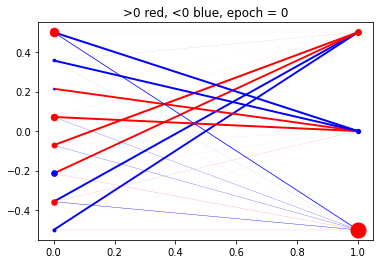

In [47]:
plotgraph(*(my_rbm.params()))

First test with 2 hidden nodes

In [51]:
my_rbm = rbm.RBM(M=2)
my_rbm.fit(v)

In [52]:
my_rbm.score(v,seq)

0.4382

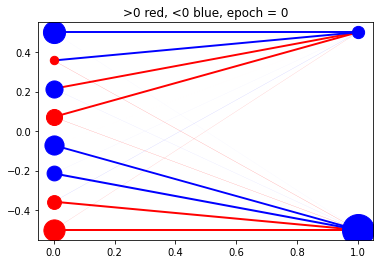

In [53]:
plotgraph(*(my_rbm.params()), M=2)

We can try different values for beta to see if the score has any improvement

In [38]:
betas = [0.01, 0.1, 1, 2,3,4,5,6,7,8,9, 10, 50]

In [41]:
scores = []
for beta in betas:
    print('beta = ', beta)
    my_rbm = rbm.RBM(M=2, beta = beta)

    my_rbm.fit(v)
    scores.append(my_rbm.score(v,seq))


beta =  0.01
beta =  0.1
beta =  1
beta =  2
beta =  3
beta =  4
beta =  5
beta =  6
beta =  7
beta =  8
beta =  9
beta =  10
beta =  50


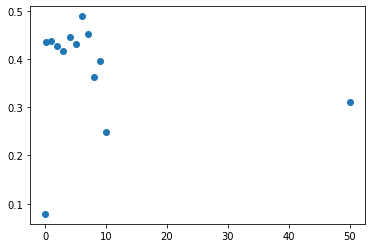

In [42]:
plt.scatter(betas, scores)